In [132]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [133]:
data = pd.read_csv("../input/creditcard.csv",header = 0)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [134]:
print ("Fraud")
print (data.Time[data.Class == 1].describe())
print ()
print ("Normal")
print (data.Time[data.Class == 0].describe())

Fraud
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

Normal
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


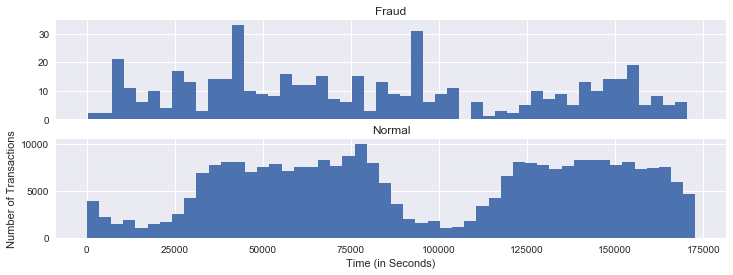

In [135]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(data.Time[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.Time[data.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

The 'Time' feature looks pretty similar across both types of transactions. You could argue that fraudulent transactions are more uniformly distributed, while normal transactions have a cyclical distribution. This could make it easier to detect a fraudulent transaction during at an 'off-peak' time.

Now let's see if the transaction amount differs between the two types.

In [136]:
print ("Fraud")
print (data.Amount[data.Class == 1].describe())
print ()
print ("Normal")
print (data.Amount[data.Class == 0].describe())

Fraud
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Normal
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


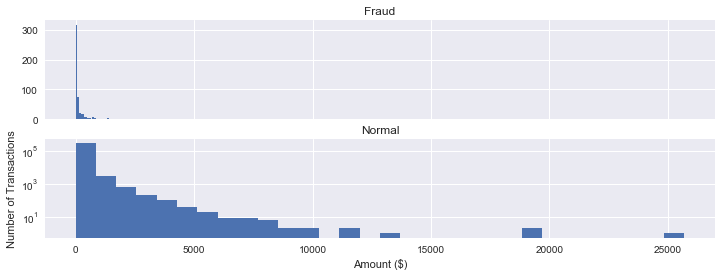

In [137]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(data.Amount[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.Amount[data.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

In [138]:
data['Amount_max_fraud'] = 1
data.loc[data.Amount <= 2125.87, 'Amount_max_fraud'] = 0

Most transactions are small amounts, less than 100.Fraudulent transactions have a max value far less than normal transactions (2,125.87 vs $25,691.16).

In [139]:
#Drop all of the features that have very similar distributions between the two types of transactions.
data = data.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1)

In [140]:
#Based on the plots above, these features are created to identify values where fraudulent transaction are more common.
data['V1_'] = data.V1.map(lambda x: 1 if x < -3 else 0)
data['V2_'] = data.V2.map(lambda x: 1 if x > 2.5 else 0)
data['V3_'] = data.V3.map(lambda x: 1 if x < -4 else 0)
data['V4_'] = data.V4.map(lambda x: 1 if x > 2.5 else 0)
data['V5_'] = data.V5.map(lambda x: 1 if x < -4.5 else 0)
data['V6_'] = data.V6.map(lambda x: 1 if x < -2.5 else 0)
data['V7_'] = data.V7.map(lambda x: 1 if x < -3 else 0)
data['V9_'] = data.V9.map(lambda x: 1 if x < -2 else 0)
data['V10_'] = data.V10.map(lambda x: 1 if x < -2.5 else 0)
data['V11_'] = data.V11.map(lambda x: 1 if x > 2 else 0)
data['V12_'] = data.V12.map(lambda x: 1 if x < -2 else 0)
data['V14_'] = data.V14.map(lambda x: 1 if x < -2.5 else 0)
data['V16_'] = data.V16.map(lambda x: 1 if x < -2 else 0)
data['V17_'] = data.V17.map(lambda x: 1 if x < -2 else 0)
data['V18_'] = data.V18.map(lambda x: 1 if x < -2 else 0)
data['V19_'] = data.V19.map(lambda x: 1 if x > 1.5 else 0)
data['V21_'] = data.V21.map(lambda x: 1 if x > 0.6 else 0)

In [141]:
#Create a new feature for normal (non-fraudulent) transactions.
data.loc[data.Class == 0, 'Normal'] = 1
data.loc[data.Class == 1, 'Normal'] = 0
#Rename 'Class' to 'Fraud'.
data = data.rename(columns={'Class': 'Fraud'})

In [142]:
#492 fraudulent transactions, 284,315 normal transactions.
#0.172% of transactions were fraud. 
print(data.Normal.value_counts())
print()
print(data.Fraud.value_counts())

1.0    284315
0.0       492
Name: Normal, dtype: int64

0    284315
1       492
Name: Fraud, dtype: int64


In [143]:
pd.set_option("display.max_columns",101)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Fraud,Amount_max_fraud,V1_,V2_,V3_,V4_,V5_,V6_,V7_,V9_,V10_,V11_,V12_,V14_,V16_,V17_,V18_,V19_,V21_,Normal
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,149.62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,2.69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,378.66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,123.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,69.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0


In [144]:
#Create dataframes of only Fraud and Normal transactions.
Fraud = data[data.Fraud == 1]
Normal = data[data.Normal == 1]

In [145]:
# Set X_train equal to 80% of the fraudulent transactions.
X_train = Fraud.sample(frac=0.8)
count_Frauds = len(X_train)

# Add 80% of the normal transactions to X_train.
X_train = pd.concat([X_train, Normal.sample(frac = 0.8)], axis = 0)

# X_test contains all the transaction not in X_train.
X_test = data.loc[~data.index.isin(X_train.index)]

In [146]:
#Shuffle the dataframes so that the training is done in a random order.
X_train = shuffle(X_train)
X_test = shuffle(X_test)

In [147]:
#Add our target features to y_train and y_test.
y_train = X_train.Fraud
y_train = pd.concat([y_train, X_train.Normal], axis=1)

y_test = X_test.Fraud
y_test = pd.concat([y_test, X_test.Normal], axis=1)

In [148]:
#Drop target features from X_train and X_test.
X_train = X_train.drop(['Fraud','Normal'], axis = 1)
X_test = X_test.drop(['Fraud','Normal'], axis = 1)

In [149]:
#Check to ensure all of the training/testing dataframes are of the correct length
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

227846
227846
56961
56961


In [150]:
'''
Due to the imbalance in the data, ratio will act as an equal weighting system for our model. 
By dividing the number of transactions by those that are fraudulent, ratio will equal the value that when multiplied
by the number of fraudulent transactions will equal the number of normal transaction. 
Simply put: # of fraud * ratio = # of normal
'''
ratio = len(X_train)/count_Frauds 

y_train.Fraud *= ratio
y_test.Fraud *= ratio


In [151]:
#Names of all of the features in X_train.
features = X_train.columns.values

#Transform each feature in features so that it has a mean of 0 and standard deviation of 1; 
#this helps with training the neural network.
for feature in features:
    mean, std = data[feature].mean(), data[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std

In [152]:
# Split the testing data into validation and testing sets
split = int(len(y_test)/2)

inputX = X_train.as_matrix()
inputY = y_train.as_matrix()
inputX_valid = X_test.as_matrix()[:split]
inputY_valid = y_test.as_matrix()[:split]
inputX_test = X_test.as_matrix()[split:]
inputY_test = y_test.as_matrix()[split:]

In [153]:
# Number of input nodes.
input_nodes = 37

# Multiplier maintains a fixed ratio of nodes between each layer.
mulitplier = 1.5 

# Number of nodes in each hidden layer
hidden_nodes1 = 18
hidden_nodes2 = round(hidden_nodes1 * mulitplier)
hidden_nodes3 = round(hidden_nodes2 * mulitplier)

# Percent of nodes to keep during dropout.
pkeep = tf.placeholder(tf.float32)

In [154]:
# input
x = tf.placeholder(tf.float32, [None, input_nodes])

# layer 1
W1 = tf.Variable(tf.truncated_normal([input_nodes, hidden_nodes1], stddev = 0.15))
b1 = tf.Variable(tf.zeros([hidden_nodes1]))
y1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

# layer 2
W2 = tf.Variable(tf.truncated_normal([hidden_nodes1, hidden_nodes2], stddev = 0.15))
b2 = tf.Variable(tf.zeros([hidden_nodes2]))
y2 = tf.nn.sigmoid(tf.matmul(y1, W2) + b2)

# layer 3
W3 = tf.Variable(tf.truncated_normal([hidden_nodes2, hidden_nodes3], stddev = 0.15)) 
b3 = tf.Variable(tf.zeros([hidden_nodes3]))
y3 = tf.nn.sigmoid(tf.matmul(y2, W3) + b3)
y3 = tf.nn.dropout(y3, pkeep)

# layer 4
W4 = tf.Variable(tf.truncated_normal([hidden_nodes3, 2], stddev = 0.15)) 
b4 = tf.Variable(tf.zeros([2]))
y4 = tf.nn.softmax(tf.matmul(y3, W4) + b4)

# output
y = y4
y_ = tf.placeholder(tf.float32, [None, 2])

In [155]:
# Parameters
training_epochs = 5 # should be 2000, it will timeout when uploading
training_dropout = 0.9
display_step = 1 # 10 
n_samples = y_train.shape[0]
batch_size = 2048
learning_rate = 0.005


In [156]:
# Cost function: Cross Entropy
cost = -tf.reduce_sum(y_ * tf.log(y))

# We will optimize our model via AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Correct prediction if the most likely value (Fraud or Normal) from softmax equals the target value.
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [157]:
accuracy_summary = [] # Record accuracy values for plot
cost_summary = [] # Record cost values for plot
valid_accuracy_summary = [] 
valid_cost_summary = [] 
stop_early = 0 # To keep track of the number of epochs before early stopping

# Save the best weights so that they can be used to make the final predictions
checkpoint = "..input/best_model.ckpt"
saver = tf.train.Saver(max_to_keep=1)

# Initialize variables and tensorflow session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs): 
        for batch in range(int(n_samples/batch_size)):
            batch_x = inputX[batch*batch_size : (1+batch)*batch_size]
            batch_y = inputY[batch*batch_size : (1+batch)*batch_size]

            sess.run([optimizer], feed_dict={x: batch_x, 
                                             y_: batch_y,
                                             pkeep: training_dropout})

        # Display logs after every 10 epochs
        if (epoch) % display_step == 0:
            train_accuracy, newCost = sess.run([accuracy, cost], feed_dict={x: inputX, 
                                                                            y_: inputY,
                                                                            pkeep: training_dropout})

            valid_accuracy, valid_newCost = sess.run([accuracy, cost], feed_dict={x: inputX_valid, 
                                                                                  y_: inputY_valid,
                                                                                  pkeep: 1})

            print ("Epoch:", epoch,
                   "Acc =", "{:.5f}".format(train_accuracy), 
                   "Cost =", "{:.5f}".format(newCost),
                   "Valid_Acc =", "{:.5f}".format(valid_accuracy), 
                   "Valid_Cost = ", "{:.5f}".format(valid_newCost))
            
            # Save the weights if these conditions are met.
            if epoch > 0 and valid_accuracy > max(valid_accuracy_summary) and valid_accuracy > 0.999:
                saver.save(sess, checkpoint)
            
            # Record the results of the model
            accuracy_summary.append(train_accuracy)
            cost_summary.append(newCost)
            valid_accuracy_summary.append(valid_accuracy)
            valid_cost_summary.append(valid_newCost)
            
            # If the model does not improve after 15 logs, stop the training.
            if valid_accuracy < max(valid_accuracy_summary) and epoch > 100:
                stop_early += 1
                if stop_early == 15:
                    break
            else:
                stop_early = 0
            
    print()
    print("Optimization Finished!")
    print()   
    
with tf.Session() as sess:
    # Load the best weights and show its results
    saver.restore(sess, checkpoint)
    training_accuracy = sess.run(accuracy, feed_dict={x: inputX, y_: inputY, pkeep: training_dropout})
    validation_accuracy = sess.run(accuracy, feed_dict={x: inputX_valid, y_: inputY_valid, pkeep: 1})
    
    print("Results using the best Valid_Acc:")
    print()
    print("Training Accuracy =", training_accuracy)
    print("Validation Accuracy =", validation_accuracy)

Epoch: 0 Acc = 0.92134 Cost = 89850.33594 Valid_Acc = 0.92177 Valid_Cost =  13511.37012
Epoch: 1 Acc = 0.94275 Cost = 66175.21094 Valid_Acc = 0.94280 Valid_Cost =  12721.86328
Epoch: 2 Acc = 0.93886 Cost = 63929.50000 Valid_Acc = 0.93954 Valid_Cost =  12989.94629
Epoch: 3 Acc = 0.95432 Cost = 58242.87891 Valid_Acc = 0.95551 Valid_Cost =  13772.51953
Epoch: 4 Acc = 0.93968 Cost = 59782.32422 Valid_Acc = 0.93943 Valid_Cost =  13300.77930

Optimization Finished!

INFO:tensorflow:Restoring parameters from ..input/best_model.ckpt


InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on ..input/best_model.ckpt: Not found: ..input
	 [[Node: save_6/RestoreV2_155 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_6/Const_0_0, save_6/RestoreV2_155/tensor_names, save_6/RestoreV2_155/shape_and_slices)]]

Caused by op 'save_6/RestoreV2_155', defined at:
  File "/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-157-8975e1008252>", line 9, in <module>
    saver = tf.train.Saver(max_to_keep=1)
  File "/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1139, in __init__
    self.build()
  File "/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 640, in restore_v2
    dtypes=dtypes, name=name)
  File "/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to get matching files on ..input/best_model.ckpt: Not found: ..input
	 [[Node: save_6/RestoreV2_155 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_6/Const_0_0, save_6/RestoreV2_155/tensor_names, save_6/RestoreV2_155/shape_and_slices)]]


In [ ]:
# Plot the accuracy and cost summaries 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

ax1.plot(accuracy_summary) # blue
ax1.plot(valid_accuracy_summary) # green
ax1.set_title('Accuracy')

ax2.plot(cost_summary)
ax2.plot(valid_cost_summary)
ax2.set_title('Cost')

plt.xlabel('Epochs (x10)')
plt.show()

In [ ]:
# Find the predicted values, then use them to build a confusion matrix
predicted = tf.argmax(y, 1)
with tf.Session() as sess:  
   # Load the best weights
   saver.restore(sess, checkpoint)
   testing_predictions, testing_accuracy = sess.run([predicted, accuracy], 
                                                    feed_dict={x: inputX_test, y_:inputY_test, pkeep: 1})
   
   print("F1-Score =", f1_score(inputY_test[:,1], testing_predictions))
   print("Testing Accuracy =", testing_accuracy)
   print()
   c = confusion_matrix(inputY_test[:,1], testing_predictions)
   show_confusion_matrix(c, ['Fraud', 'Normal'])


In [ ]:
#reload the original dataset
tsne_data = pd.read_csv("../input/creditcard.csv")

#Set df2 equal to all of the fraulent and 10,000 normal transactions.
df2 = tsne_data[tsne_data.Class == 1]
df2 = pd.concat([df2, tsne_data[tsne_data.Class == 0].sample(n = 10000)], axis = 0)

#Scale features to improve the training ability of TSNE.
standard_scaler = StandardScaler()
df2_std = standard_scaler.fit_transform(df2)

#Set y equal to the target values.
y = df2.iloc[:,-1].values

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(df2_std)

In [ ]:
#Build the scatter plot with the two types of transactions.
color_map = {0:'red', 1:'blue'}
plt.figure()
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = x_test_2d[y==cl,0], 
                y = x_test_2d[y==cl,1], 
                c = color_map[idx], 
                label = cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()

The are two main groupings of fraudulent transactions, while the remaineder are mixed within the rest of the data.

Note: I have only used 10,000 of the 284,315 normal transactions for this visualization. I would have liked to of used more, but my laptop crashes if many more than 10,000 transactions are included. With only 3.15% of the data being used, there should be some accuracy to this plot, but I am confident that the layout would look different if all of the transactions were included.

In [ ]:
#Set df_used to the fraudulent transactions' dataset.
data_used = Fraud

#Add 10,000 normal transactions to df_used.
data_used = pd.concat([data_used, Normal.sample(n = 10000)], axis = 0)

#Scale features to improve the training ability of TSNE.
data_used_std = standard_scaler.fit_transform(data_used)

#Set y_used equal to the target values.
y_used = data_used.ix[:,-1].values

In [ ]:
x_test_2d_used = tsne.fit_transform(data_used_std)

In [ ]:
color_map = {1:'red', 0:'blue'}
plt.figure()
for idx, cl in enumerate(np.unique(y_used)):
    plt.scatter(x=x_test_2d_used[y_used==cl,0], 
                y=x_test_2d_used[y_used==cl,1], 
                c=color_map[idx], 
                label=cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()

It appears that the work we did in the feature engineering stage of this analysis has been for the best. We can see that the fraudulent transactions are all part of a group of points. This suggests that it is easier for a model to identify the fraudulent transactions in the testing data, and to learn about the traits of the fraudulent transactions in the training data.
